In [34]:
import pandas as pd
import numpy as np
import torch
import esm

In [35]:
import gc
import os

In [ ]:
from pathlib import Path
import torch, json
from datetime import datetime

save_dir = Path("backend/weights")
save_dir.mkdir(parents=True, exist_ok=True)

best_acc = -1.0

In [37]:
data = np.load("data/cullpdb+profile_5926_filtered.npy.gz", allow_pickle=True)

In [38]:
N = data.shape[0]
L, D = 700, 57
arr = data.reshape(N, L, D)

In [39]:
print("arr shape:", arr.shape)

arr shape: (5365, 700, 57)


In [41]:
# Amino acid mapping (20 + X + padding)
AA_CODES = list("ACDEFGHIKLMNPQRSTVWY") + ['X'] + ['-']
# Q8 code order from dataset description
Q8_ORDER = ['L','B','E','G','I','H','S','T','-']
# Q8 → Q3 mapping: 0=Helix, 1=Strand, 2=Coil, 3=Padding
Q8_TO_Q3 = np.array([2, 1, 1, 0, 0, 0, 2, 2, 3])

def extract_features_labels(data):
    """
    Extract AA one-hot, N/C terminal flags, and Q3 labels from CullPDB array.
    Returns:
        features: list of np.arrays (n_residues, 24)  # 22 AA + 2 terminal flags
        labels_q3: list of np.arrays (n_residues,)    # Q3 labels (0,1,2)
        sequences: list of str                       # decoded AA sequences
    """
    N = data.shape[0]
    L, D = 700, 57
    arr = data.reshape(N, L, D)

    features = []
    labels_q3 = []
    sequences = []

    for prot in arr:
        # Blocks from dataset description
        aa_onehot = prot[:, 0:22]
        q8_onehot = prot[:, 22:31]
        nc_flags = prot[:, 31:33]  # N-term / C-term

        # Decode Q8 index and mask padding
        q8_idx = q8_onehot.argmax(axis=1)
        mask = q8_idx != 8  # not "NoSeq"

        # Q3 labels
        q3_idx = Q8_TO_Q3[q8_idx]
        q3_idx = q3_idx[mask]  # remove padding

        # Features = AA one-hot + N/C flags
        feat = np.concatenate([aa_onehot[mask], nc_flags[mask]], axis=1)

        # Decode AA sequence (optional, for inspection)
        aa_idx = aa_onehot.argmax(axis=1)
        seq = "".join(AA_CODES[i] for i in aa_idx[mask])

        features.append(feat)
        labels_q3.append(q3_idx)
        sequences.append(seq)

    return features, labels_q3, sequences


# Example usage
data = np.load("data/cullpdb+profile_5926_filtered.npy.gz", allow_pickle=True)
features, q3_labels, sequences = extract_features_labels(data)

print("Protein 0:")
print("Sequence:", sequences[0])
print("Features shape:", features[0].shape)  # (len_protein, 24)
print("Q3 labels:", q3_labels[0])



Protein 0:
Sequence: GEYPTWYGANPYFMSTHDMFDRDGWENTMENPIKXWHKAAVFFFYTNSNNWWHNGKWEDRMCENMYGKETEPQMWQXQARYYTMARESHAHQKFPHXAFWDWPMTEEGGAEDKRHRDNYWHQMMXTNWPFAERHMPFKQWWDNQWMTNAFEVRHMQPNGWMYAWKYWNQVIFDYMSSFHEIATWAFTRKEHHSIDPGWDNEDWWNHRTKRXKENMMTMKTKEDRFKEHRYTWSMRGADEFRCTWIRFRPNWWWRFRFKGWRKFDKNRMFFKESNAHYMEYTWNMTENNHPMATKETMWMSTSNWYFFKRMDWWSK
Features shape: (315, 24)
Q3 labels: [2 2 2 2 1 1 1 2 2 2 2 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 0 0 0 0 2 2 1 1 1 1
 1 1 1 1 1 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 2 0 0 0 0 2 2 2 1 1 2 2 2 2 2 1 2
 1 1 2 2 0 0 0 1 1 1 2 2 2 1 1 1 1 2 2 2 2 2 1 1 1 1 1 1 1 1 2 0 0 0 0 0 2
 0 0 0 0 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 2 2 2 1 1 2 2 2 2 2 2 2 2 2
 0 0 0 1 1 1 2 2 2 2 1 1 1 1 1 1 1 1 1 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 2 1 1 1 1 1 1 1 2 2 2 2 0 0 0 2 1 1 1 1 1 1 1 2 2 2 2 1 1 1 1 1 1 1 1 1 2
 2 2 2 2 1 1 1 1 1 1 1 1 1 1 2 2 2 2 1 1 1 1 1 1 2 2 2 2 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 2 2 0 0 0 2 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 2 2 2 2 1 1 1

In [9]:
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
batch_converter = alphabet.get_batch_converter()

In [10]:
model.eval()
for p in model.parameters():
    p.requires_grad = False

In [42]:
AA_seqs_data = [(f"protein_{i}", seq) for i, seq in enumerate(sequences)]

In [ ]:
os.makedirs("embeddings", exist_ok=True)

model.eval()
for p in model.parameters():
    p.requires_grad = False

BATCH_SIZE = 100       # how many to process in memory at once
start_protein = 0
end_protein = 1000    # total sequences to process
LAYER = 6              # ESM layer to extract

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for start in range(start_protein, end_protein, BATCH_SIZE):
    end = min(start + BATCH_SIZE, end_protein)
    print(f"Processing sequences {start} to {end-1}")

    AA_seqs_data = [(f"protein_{i}", seq) for i, seq in enumerate(sequences[start:end], start=start)]
    batch_labels, batch_strs, batch_tokens = batch_converter(AA_seqs_data)
    batch_tokens = batch_tokens.to(device)

    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[LAYER])
        token_embeddings = results["representations"][LAYER].cpu().numpy()  # (batch_size, max_length, emb_dim)

    # Save each protein embedding separately, removing padding and special tokens
    for i, (label, seq) in enumerate(zip(batch_labels, batch_strs)):
        seq_len = len(seq)
        protein_emb = token_embeddings[i, 1:seq_len+1]  # remove BOS/EOS tokens
        np.save(f"embeddings/{label}_emb.npy", protein_emb)

    del batch_tokens, results, token_embeddings
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


Processing sequences 0 to 99
Processing sequences 100 to 199
Processing sequences 200 to 299
Processing sequences 300 to 399
Processing sequences 400 to 499
Processing sequences 500 to 599
Processing sequences 600 to 699
Processing sequences 700 to 799
Processing sequences 800 to 899
Processing sequences 900 to 999
✅ Processed and saved embeddings for 2065 sequences.


In [47]:
def load_embeddings_to_array(folder="embeddings", max_count=None, sort=True):
    """
    Load per-protein .npy embeddings from a folder and combine into a list.
    Handles variable-length protein embeddings (no padding).

    Args:
        folder (str): Path to the folder containing .npy embedding files.
        max_count (int or None): Number of embeddings to load. 
                                 If None, load all files.
        sort (bool): Sort files by name before loading.

    Returns:
        names (list[str]): Protein names in the same order as list entries.
        embeddings (list[np.ndarray]): Each entry is (protein_length, embedding_dim)
    """
    files = [f for f in os.listdir(folder) if f.endswith(".npy")]
    if sort:
        files.sort()
    if max_count is not None:
        files = files[:max_count]

    embeddings = []
    names = []
    for fname in files:
        path = os.path.join(folder, fname)
        emb = np.load(path)  # shape: (protein_length, embedding_dim)
        embeddings.append(emb)
        names.append(os.path.splitext(fname)[0])  # unique name per protein

    return names, embeddings

In [49]:
names, emb_array = load_embeddings_to_array("embeddings", max_count=5500)
print("Shape:", len(emb_array))
print("First 5 names:", names[:5])
print(emb_array[0].shape)

Shape: 5365
First 5 names: ['protein_0_emb', 'protein_1000_emb', 'protein_1001_emb', 'protein_1002_emb', 'protein_1003_emb']
(315, 320)


In [50]:
import re

def extract_index(name):
    match = re.search(r'protein_(\d+)_emb', name)
    return int(match.group(1)) if match else -1

sorted_pairs = sorted(zip(names, emb_array), key=lambda x: extract_index(x[0]))
names_sorted, emb_array_sorted = zip(*sorted_pairs)
names = list(names_sorted)
emb_array = list(emb_array_sorted)

In [51]:

protein_inputs = []
for i, name in enumerate(names):
    emb = emb_array[i]  # shape: (protein_length, embedding_dim)
    labels = q3_labels[i]  # shape: (protein_length,)
    # Ensure lengths match
    if emb.shape[0] == len(labels):
        protein_inputs.append((torch.tensor(emb, dtype=torch.float32), torch.tensor(labels, dtype=torch.long)))
    else:
        print(f"Warning: Length mismatch for {name}")

# Now protein_inputs is a list of (embedding_matrix, label_vector) tuples
print(protein_inputs)

[(tensor([[ 0.1302,  0.1632,  0.2888,  ...,  0.1957, -0.1322, -0.5956],
        [ 0.2530, -0.3770,  0.1877,  ...,  0.0174, -0.0739, -0.1022],
        [-0.1744, -0.0730,  0.2751,  ..., -0.1269, -0.0565, -0.3023],
        ...,
        [ 0.3078,  0.2568, -0.2026,  ..., -0.0545, -0.0945, -0.1158],
        [-0.2438, -0.1002, -0.4044,  ...,  0.1521,  0.2968, -0.3561],
        [ 0.1615,  0.3238,  0.1479,  ..., -0.3572, -0.0415, -0.3630]]), tensor([2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 0, 0, 0, 0, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2,
        1, 2, 1, 1, 2, 2, 0, 0, 0, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
   

In [52]:
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.utils.rnn as rnn_utils
import torch.nn as nn

In [58]:
class ProteinDataset(Dataset):
    def __init__(self, protein_inputs):
        self.protein_inputs = protein_inputs

    def __len__(self):
        return len(self.protein_inputs)

    def __getitem__(self, idx):
        emb, label = self.protein_inputs[idx]
        return emb, label

def collate_batch(batch):
    embs, labels = zip(*batch)
    embs_padded = rnn_utils.pad_sequence(embs, batch_first=True)
    labels_padded = rnn_utils.pad_sequence(labels, batch_first=True, padding_value=-1)
    lengths = torch.tensor([len(l) for l in labels])
    return embs_padded, labels_padded, lengths

# Split into train/val sets (e.g., 80% train, 20% val)
dataset = ProteinDataset(protein_inputs)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)

# Example: check batch shapes
for batch_embs, batch_labels, batch_lengths in train_loader:
    print("Train batch:", batch_embs.shape, batch_labels.shape, batch_lengths)
    break
for batch_embs, batch_labels, batch_lengths in val_loader:
    print("Val batch:", batch_embs.shape, batch_labels.shape, batch_lengths)
    break

len(train_dataset)

Train batch: torch.Size([32, 471, 320]) torch.Size([32, 471]) tensor([192, 440, 149, 105, 176, 141,  46, 216, 276, 191, 123, 363, 340, 132,
        109, 384, 231, 180, 143, 269, 412, 206, 205,  89, 471,  92, 293,  99,
        157, 106, 351, 238])
Val batch: torch.Size([32, 479, 320]) torch.Size([32, 479]) tensor([309, 170, 260,  67, 257, 479, 130,  43, 328, 214, 347, 321, 434,  79,
        244, 364, 296,  98, 135, 102, 408, 275, 162, 247,  88, 111, 178, 303,
         80, 113, 261,  77])


4292

In [59]:
# Example: simple linear classifier for each protein
class ProteinClassifier(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super().__init__()
        self.convLayers = nn.Sequential(
            nn.Conv1d(in_channels=embedding_dim, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=32, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=32, kernel_size=15, padding=7),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=32, kernel_size=21, padding=10)  # Final conv layer
        )
        self.classifier = nn.Sequential(
            nn.Linear(32, 32),  # 32 is out_channels from last Conv1d
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        # x: (batch, seq_len, embedding_dim)
        x = x.transpose(1, 2)  # (batch, embedding_dim, seq_len) for Conv1d
        x = self.convLayers(x) # (batch, 8, seq_len)
        x = x.transpose(1, 2)  # (batch, seq_len, 8)
        logits = self.classifier(x)  # (batch, seq_len, num_classes)
        return logits
    
        
    def forward(self, x):
        # x: (batch, seq_len, embedding_dim)
        x = x.transpose(1, 2)  # (batch, embedding_dim, seq_len) for Conv1d
        x = self.convLayers(x) # (batch, 8, seq_len)
        x = x.transpose(1, 2)  # (batch, seq_len, 8)
        logits = self.classifier(x)  # (batch, seq_len, num_classes)
        return logits

In [60]:
embedding_dim = protein_inputs[0][0].shape[1]
num_classes = 3  # Q3 labels
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ProteinClassifier(embedding_dim, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)  # ignore padding


num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_embs, batch_labels, batch_lengths in train_loader:
        batch_embs = batch_embs.to(device)
        batch_labels = batch_labels.to(device)
        optimizer.zero_grad()
        logits = model(batch_embs)  # (batch, seq_len, num_classes)
        loss = criterion(logits.view(-1, num_classes), batch_labels.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {avg_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_embs, batch_labels, batch_lengths in val_loader:
            batch_embs = batch_embs.to(device)
            batch_labels = batch_labels.to(device)
            logits = model(batch_embs)
            loss = criterion(logits.view(-1, num_classes), batch_labels.view(-1))
            val_loss += loss.item()
            # Accuracy calculation
            preds = logits.argmax(dim=-1)  # (batch, seq_len)
            mask = batch_labels != -1      # ignore padding
            correct += (preds[mask] == batch_labels[mask]).sum().item()
            total += mask.sum().item()
    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct / total if total > 0 else 0
    print(f"Epoch {epoch+1}/{num_epochs} - Val loss: {avg_val_loss:.4f} - Val acc: {val_acc:.4f}")

    print(f"Epoch {epoch+1}/{num_epochs} - Val loss: {avg_val_loss:.4f} - Val acc: {val_acc:.4f}")

if val_acc > best_acc:
    best_acc = val_acc
    ckpt_path = save_dir / "minissp_best.pt"
    meta_path = save_dir / "meta.json"

    # Save weights (state_dict) + minimal metadata
    torch.save(
        {
            "state_dict": model.state_dict(),
            "embedding_dim": embedding_dim,
            "num_classes": num_classes,
            "epoch": epoch + 1,
            "val_acc": best_acc,
        },
        ckpt_path,
    )

    with open(meta_path, "w") as f:
        json.dump(
            {
                "embedding_dim": int(embedding_dim),
                "num_classes": int(num_classes),
                "label_map": {0: "H", 1: "E", 2: "C"},  # adjust if different
                "saved_at": datetime.now().isoformat(timespec="seconds"),
            },
            f,
            indent=2,
        )

    print(f"✓ Saved best checkpoint to {ckpt_path} (acc={best_acc:.4f})")

Epoch 1/50 - Train loss: 1.0328
Epoch 1/50 - Val loss: 0.9025 - Val acc: 0.5698
Epoch 1/50 - Val loss: 0.9025 - Val acc: 0.5698
Epoch 2/50 - Train loss: 0.8764
Epoch 2/50 - Val loss: 0.8373 - Val acc: 0.6212
Epoch 2/50 - Val loss: 0.8373 - Val acc: 0.6212
Epoch 3/50 - Train loss: 0.8239
Epoch 3/50 - Val loss: 0.8053 - Val acc: 0.6425
Epoch 3/50 - Val loss: 0.8053 - Val acc: 0.6425
Epoch 4/50 - Train loss: 0.7776
Epoch 4/50 - Val loss: 0.7672 - Val acc: 0.6627
Epoch 4/50 - Val loss: 0.7672 - Val acc: 0.6627
Epoch 5/50 - Train loss: 0.7566
Epoch 5/50 - Val loss: 0.7387 - Val acc: 0.6766
Epoch 5/50 - Val loss: 0.7387 - Val acc: 0.6766
Epoch 6/50 - Train loss: 0.7414
Epoch 6/50 - Val loss: 0.7649 - Val acc: 0.6674
Epoch 6/50 - Val loss: 0.7649 - Val acc: 0.6674
Epoch 7/50 - Train loss: 0.7338
Epoch 7/50 - Val loss: 0.7214 - Val acc: 0.6840
Epoch 7/50 - Val loss: 0.7214 - Val acc: 0.6840
Epoch 8/50 - Train loss: 0.7247
Epoch 8/50 - Val loss: 0.7107 - Val acc: 0.6905
Epoch 8/50 - Val loss: 0

KeyboardInterrupt: 

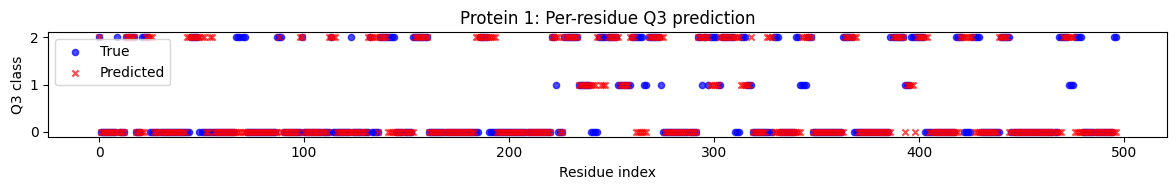

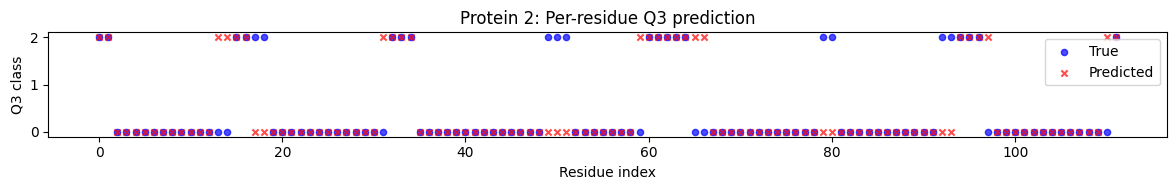

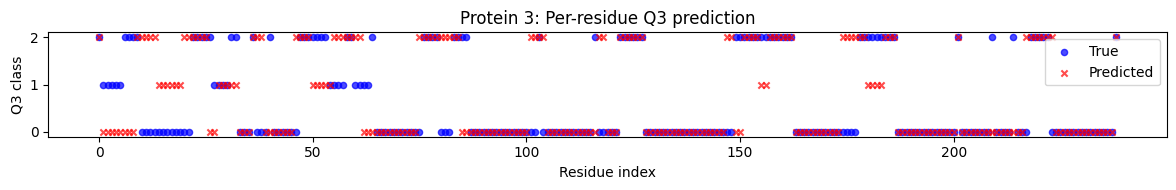

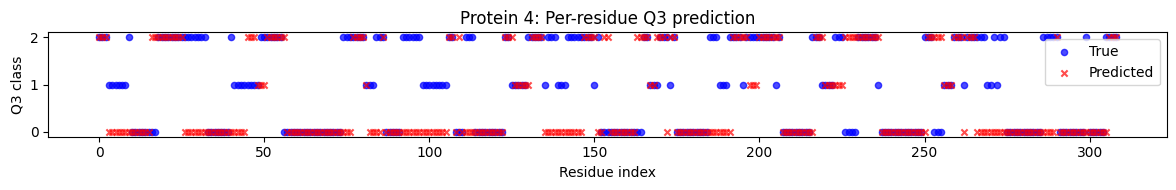

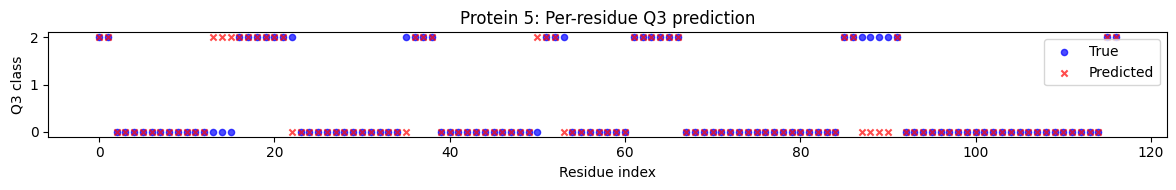

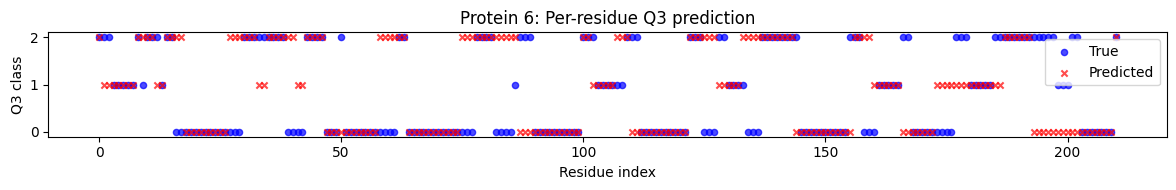

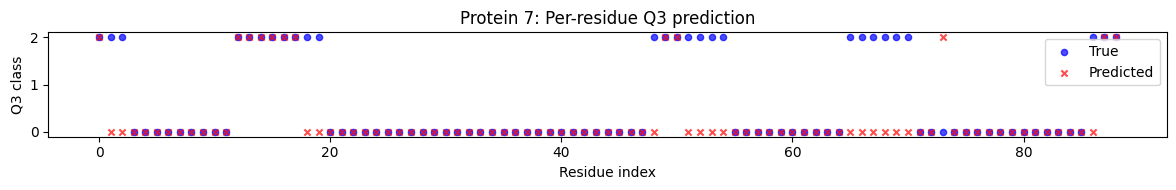

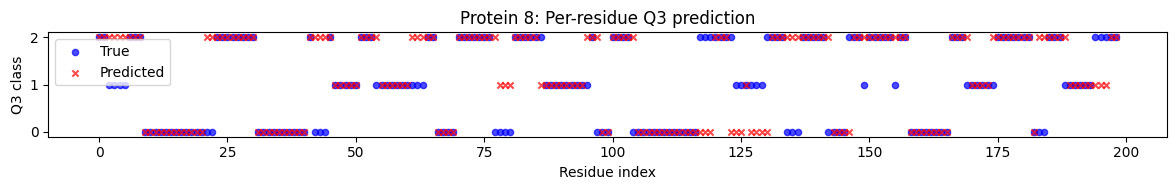

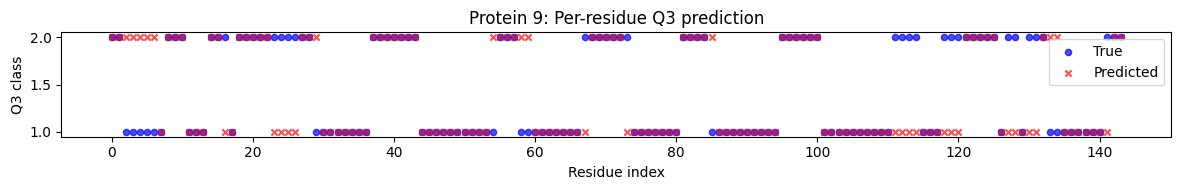

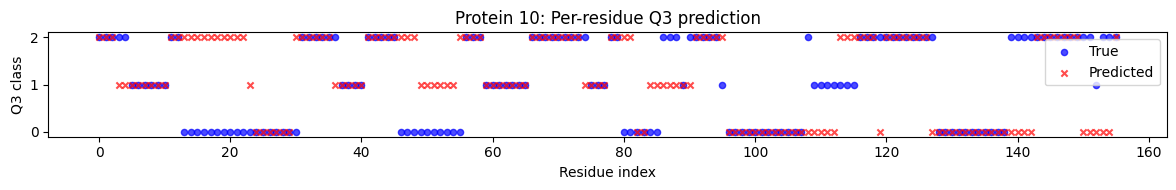

In [ ]:
import matplotlib.pyplot as plt

# Get one batch from the validation loader
model.eval()
with torch.no_grad():
    for batch_embs, batch_labels, batch_lengths in val_loader:
        batch_embs = batch_embs.to(device)
        logits = model(batch_embs)  # (batch, seq_len, num_classes)
        preds = logits.argmax(dim=-1).cpu().numpy()  # (batch, seq_len)
        batch_labels = batch_labels.cpu().numpy()
        # Plot for up to 10 proteins in this batch
        n_proteins = min(10, batch_embs.shape[0])
        for i in range(n_proteins):
            length = batch_lengths[i].item()
            true_labels = batch_labels[i][:length]
            pred_labels = preds[i][:length]
            plt.figure(figsize=(12, 2))
            plt.scatter(range(length), true_labels, label="True", color="blue", alpha=0.7, s=20)
            plt.scatter(range(length), pred_labels, label="Predicted", color="red", alpha=0.7, s=20, marker='x')
            plt.xlabel("Residue index")
            plt.ylabel("Q3 class")
            plt.title(f"Protein {i+1}: Per-residue Q3 prediction")
            plt.legend()
            plt.tight_layout()
            plt.show()
        break

In [ ]:
import torch
from pathlib import Path

model.eval()

# Example input that matches your model’s expected shape
# (e.g., tokens shape [1, L] where L is sequence length)
example_tokens = torch.randint(0, 20, (1, 1000))  # adjust to your tokenizer/shape

traced = torch.jit.trace(model, example_tokens)   # or torch.jit.script(model) if control-flow
outdir = Path("backend/weights")
outdir.mkdir(parents=True, exist_ok=True)
ts_path = outdir / f"minissp_{torch.randint(0,1_000_000,(1,)).item()}.ts"
traced.save(str(ts_path))

print("Saved TorchScript:", ts_path)

In [61]:

class FeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # Each feature: (seq_len, 24), label: (seq_len,)
        return torch.tensor(self.features[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

def collate_feature_batch(batch):
    feats, labels = zip(*batch)
    feats_padded = rnn_utils.pad_sequence(feats, batch_first=True)
    labels_padded = rnn_utils.pad_sequence(labels, batch_first=True, padding_value=-1)
    lengths = torch.tensor([len(l) for l in labels])
    return feats_padded, labels_padded, lengths

# Prepare dataset and loaders
feature_dataset = FeatureDataset(features, q3_labels)
train_size = int(0.8 * len(feature_dataset))
val_size = len(feature_dataset) - train_size
train_dataset, val_dataset = random_split(feature_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_feature_batch)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_feature_batch)

In [68]:
# Example: simple linear classifier for each protein
class ProteinClassifier2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.convLayers = nn.Sequential(
            nn.Conv1d(in_channels=24, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=16, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=15, padding=7),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=32, kernel_size=21, padding=10)  # Final conv layer
        )
        self.classifier = nn.Sequential(
            nn.Linear(32, 32),  # 32 is out_channels from last Conv1d
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        # x: (batch, seq_len, embedding_dim)
        x = x.transpose(1, 2)  # (batch, embedding_dim, seq_len) for Conv1d
        x = self.convLayers(x) # (batch, 8, seq_len)
        x = x.transpose(1, 2)  # (batch, seq_len, 8)
        logits = self.classifier(x)  # (batch, seq_len, num_classes)
        return logits

In [ ]:

num_classes = 3  # Q3 labels
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ProteinClassifier2(num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)

num_epochs = 20
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_feats, batch_labels, batch_lengths in train_loader:
        batch_feats = batch_feats.to(device)
        batch_labels = batch_labels.to(device)
        optimizer.zero_grad()
        # Add channel dimension for Conv1d: (batch, seq_len, 24) -> (batch, seq_len, 1, 24) -> (batch, seq_len, 24)
        x = batch_feats.unsqueeze(2) if batch_feats.dim() == 3 else batch_feats
        # For ProteinClassifier2, input should be (batch, seq_len, 24), but Conv1d expects (batch, 1, seq_len, 24)
        # So we transpose to (batch, seq_len, 24) -> (batch, 24, seq_len)
        logits = model(batch_feats)  # (batch, seq_len, num_classes)
        loss = criterion(logits.view(-1, num_classes), batch_labels.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {avg_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_feats, batch_labels, batch_lengths in val_loader:
            batch_feats = batch_feats.to(device)
            batch_labels = batch_labels.to(device)
            logits = model(batch_feats)
            loss = criterion(logits.view(-1, num_classes), batch_labels.view(-1))
            val_loss += loss.item()
            preds = logits.argmax(dim=-1)
            mask = batch_labels != -1
            correct += (preds[mask] == batch_labels[mask]).sum().item()
            total += mask.sum().item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_acc = correct / total if total > 0 else 0
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}/{num_epochs} - Val loss: {avg_val_loss:.4f} - Val acc: {val_acc:.4f}")



Epoch 1/20 - Train loss: 0.9973
Epoch 1/20 - Val loss: 0.8912 - Val acc: 0.5922
Epoch 2/20 - Train loss: 0.8771
Epoch 2/20 - Val loss: 0.8496 - Val acc: 0.6177
Epoch 3/20 - Train loss: 0.8272
Epoch 3/20 - Val loss: 0.8059 - Val acc: 0.6459
Epoch 4/20 - Train loss: 0.7855
Epoch 4/20 - Val loss: 0.7665 - Val acc: 0.6623
Epoch 5/20 - Train loss: 0.7695
Epoch 5/20 - Val loss: 0.7501 - Val acc: 0.6704
Epoch 6/20 - Train loss: 0.7593
Epoch 6/20 - Val loss: 0.7829 - Val acc: 0.6548
Epoch 7/20 - Train loss: 0.7499
Epoch 7/20 - Val loss: 0.7366 - Val acc: 0.6773
Epoch 8/20 - Train loss: 0.7423
Epoch 8/20 - Val loss: 0.7497 - Val acc: 0.6747
Epoch 9/20 - Train loss: 0.7395
Epoch 9/20 - Val loss: 0.7270 - Val acc: 0.6823
Epoch 10/20 - Train loss: 0.7328
Epoch 10/20 - Val loss: 0.7226 - Val acc: 0.6836
Epoch 11/20 - Train loss: 0.7302
Epoch 11/20 - Val loss: 0.7197 - Val acc: 0.6857
Epoch 12/20 - Train loss: 0.7268
Epoch 12/20 - Val loss: 0.7172 - Val acc: 0.6872
Epoch 13/20 - Train loss: 0.7257
E

ModuleNotFoundError: No module named 'matplotlib'

Unable to revert mtime: /Library/Fonts
Matplotlib is building the font cache; this may take a moment.


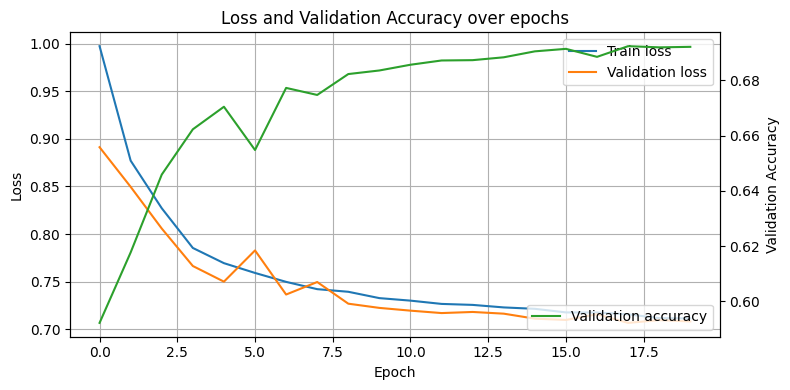

In [71]:
# Plot loss and accuracy
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(8, 4))
ax1.plot(train_losses, label="Train loss", color="tab:blue")
ax1.plot(val_losses, label="Validation loss", color="tab:orange")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Loss and Validation Accuracy over epochs")
ax1.legend(loc="upper right")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(val_accuracies, label="Validation accuracy", color="tab:green")
ax2.set_ylabel("Validation Accuracy")
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [74]:
save_dir = Path("website/backend/weights")

ckpt_path = save_dir / "minissp_best.pt"
torch.save({
    "state_dict": model.state_dict(),
    "num_classes": num_classes,
    "arch": "ProteinClassifier2",
    "val_acc": float(best_acc),
    "saved_at": datetime.now().isoformat(timespec="seconds"),
}, ckpt_path)